In [1]:
# %pip install --user "jax[cpu]"
# %pip install --user flax
# %pip install --user optax

In [2]:
import optax
import flax
import jax

import scipy.stats as st
# not a fan of the FLAX/JAX nn imports, especially considering most models in this repository use PyTorch nn
import flax.linen as ln
import jax.numpy as jnp
import numpy as np
import pandas as pd
import seaborn as sns

from torch.utils.data import Dataset, DataLoader
from flax.training import train_state

In [3]:
class Linear(ln.Module):
    @ln.compact
    def __call__(self, x):
        x = ln.Dense(features=1, use_bias=False)(x)
        return x
    
# https://colab.research.google.com/github/phlippe/uvadlc_notebooks/blob/master/docs/tutorial_notebooks/JAX/tutorial2/Introduction_to_JAX.ipynb#scrollTo=3qjS60Zl-I2_
model = Linear()

In [4]:
class GaussianReturns(Dataset):
    def __init__(self, size, cov, mean, cov_noise=None, noise_batch=32, reshuffle=True, seed=None):
        super().__init__()
        cov = np.asarray(cov)
        mean = np.asarray(mean)
        self._data = self._generate_returns(size, mean, cov, cov_noise, noise_batch, reshuffle)
        return
        
    def _noisy_cov(self, cov, cov_noise):
        return np.clip(cov + np.random.normal(cov.shape) * cov_noise, 0, 1)
        
    def _generate_returns(self, size, mean, cov, cov_noise, noise_batch, reshuffle):
        n_even = size // noise_batch
        size_uneven = size % noise_batch
        samples = list()
        assert cov.shape[0] == cov.shape[1] == mean.shape[0], f'{cov.shape} | {mean.shape}'
        
        for _ in range(n_even):
            # should provide option to input list of cov_noise offsets
            ncov = cov if cov_noise is None else self._noisy_cov(cov, cov_noise)
            sample = st.multivariate_normal(mean, cov).rvs(size=noise_batch)
            assert sample.shape == (noise_batch, cov.shape[0])
            samples.append(sample)
            
        if size_uneven:
            key1, key2 = jax.random.split(self.rng, num=2)
            ncov = cov if cov_noise is None else self._noisy_cov(cov, cov_noise)
            sample = st.multivariate_normal(mean, cov).rvs(size=size_uneven)
            samples.append(sample)
            
        return_array = np.concatenate(samples, axis=0)
        assert return_array.shape == (size, cov.shape[1])
        if reshuffle:
            return_array = np.random.permutation(return_array)
        return return_array
        
    def __len__(self):
        return self._data.shape[0]
    
    @property
    def shape(self):
        return self._data.shape

    def __getitem__(self, idx):
        data_point = self._data[idx]
        return data_point
    
# This collate function is taken from the JAX tutorial with PyTorch Data Loading
# https://jax.readthedocs.io/en/latest/notebooks/Neural_Network_and_Data_Loading.html
def numpy_collate(batch):
    if isinstance(batch[0], np.ndarray):
        return np.stack(batch)
    elif isinstance(batch[0], (tuple,list)):
        transposed = zip(*batch)
        return [numpy_collate(samples) for samples in transposed]
    else:
        return np.array(batch)

dataset = GaussianReturns(256, [[.001, .0001], [.0001, .001]], [.001, .002])
dataloader = DataLoader(dataset, batch_size=128, shuffle=True, collate_fn=numpy_collate)

In [5]:
rng = jax.random.PRNGKey(42)
rng, inpt_rng, init_rng = jax.random.split(rng, 3)

inpt_array = jax.random.normal(inpt_rng, (8, 2))
params = model.init(init_rng, inpt_array)

In [82]:
optimizer = optax.adamw(learning_rate=.1)

In [83]:
model_state = train_state.TrainState.create(
    apply_fn=model.apply,
    params=params,
    tx=optimizer,
)

In [133]:
def dot_returns(state, params, data):
    logits = state.apply_fn(params, data)
    #####################################
    logits = jnp.clip(logits, .2, .7)
    #####################################
    weights = ln.softmax(logits)
    pfl_returns = jnp.multiply(data, weights).sum(axis=1)    
    return pfl_returns
    
def sharpe_loss(state, params, data, constraints=[(.6, .8),(.2, .4)], gamma=[.5, .2, .2, 1.2], min_cvar=-.05):
    min_weights, max_weights = zip(*constraints)
    pfl_returns = state.apply_fn(params, data).squeeze()
    exp_mean = pfl_returns.mean(axis=0)
    exp_var = pfl_returns.std(axis=0)
    exp_cvar = jax.lax.slice_in_dim(jnp.argpartition(pfl_returns, k), 0, k, axis=0).mean()

    w = params['params']['Dense_0']['kernel']
    
    # sharpe, minimized instead of maximized
    loss = -exp_mean / (exp_var + 1e-7)
    loss += gamma[0] * (jnp.sum(w) - 1) ** 2
    loss += gamma[1] * (jnp.minimum(w - jnp.array(min_weights), 0).sum() ** 2)
    loss += gamma[2] * (jnp.minimum(jnp.array(max_weights) - w, 0).sum() ** 2)
    loss += gamma[3] * (jnp.minimum(exp_cvar - min_cvar, 0).sum() ** 2)
    return loss

def cvar_loss(state, params, data):
    k = int(data.shape[0] * .05)
    pfl_returns = state.apply_fn(params, data).squeeze()
    exp_mean = jnp.mean(pfl_returns)
    exp_cvar = jax.lax.slice(jnp.argpartition(pfl_returns, k), (0,), (k,)).mean()
    
    # sharpe, minimized instead of maximized
    loss = exp_mean / (exp_mean - exp_cvar) 
    return loss

In [134]:
# batch = next(iter(data_loader))
# calculate_loss_acc(model_state, model_state.params, batch)

In [135]:
@jax.jit  # Jit the function for efficiency
def train_step(state, batch):
    # Gradient function
    grad_fn = jax.value_and_grad(
        sharpe_loss,  # Function to calculate the loss
        argnums=1,  # Parameters are second argument of the function
        has_aux=False,
    )
    loss, grads = grad_fn(state, state.params, batch)
    state = state.apply_gradients(grads=grads)
    return state, loss

In [136]:
@jax.jit  # Jit the function for efficiency
def eval_step(state, batch):
    # Determine the accuracy
    _, acc = calculate_loss_acc(state, state.params, batch)
    return acc

In [137]:
from tqdm import tqdm
import matplotlib.pyplot as plt

def train_model(state, dataloader, num_epochs=100):
    losss = list()
    for epoch in tqdm(range(num_epochs)):
        epoch_losss = list()
        for batch in dataloader:
            state, loss = train_step(state, batch)
            epoch_losss.append(loss)
        
        losss.append(jnp.mean(jnp.array(epoch_losss)))
                   
    plt.figure(figsize=(15,5))
    plt.plot(losss)
    plt.show()
    return state

def single_batch_train_model(state, data, num_epochs=100):
    weights = list()
    losss = list()
#     data = jnp.expand_dims(data, axis=0)
    print(data.shape)
    for epoch in tqdm(range(num_epochs)):
        state, loss = train_step(state, data)
#         display(state)
#         assert False
        weights.append(state.params['params']['Dense_0']['kernel'].ravel())
        losss.append(loss)  
    
    print(weights[-1])
    df = pd.DataFrame({f'A{i}' : weight_arr[10:] for i, weight_arr in enumerate(zip(*weights))})
    display(df)
    plt.figure(figsize=(15,5))
    sns.lineplot(data=df.astype(np.float32))
    plt.show()
            
    plt.figure(figsize=(15,5))
    plt.plot(losss)
    plt.show()
    return state

In [138]:
display(dataset._data.shape)

(256, 2)

(256, 2)


100%|██████████| 1000/1000 [00:00<00:00, 3477.34it/s]

[0.40250295 0.5974407 ]


,A0,A1
0,0.5097755,0.60111415
1,0.50659156,0.6300297
2,0.49317673,0.6455188
3,0.47102314,0.64920235
4,0.442424,0.64358354
...,...,...
985,0.39798236,0.59179205
986,0.39798456,0.5870407
987,0.4082128,0.59200686
988,0.41057545,0.6011664


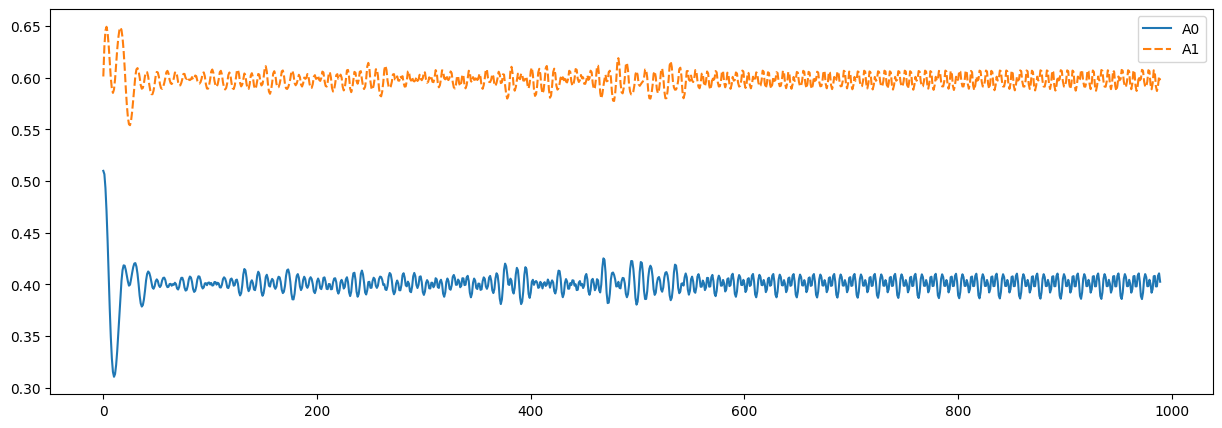

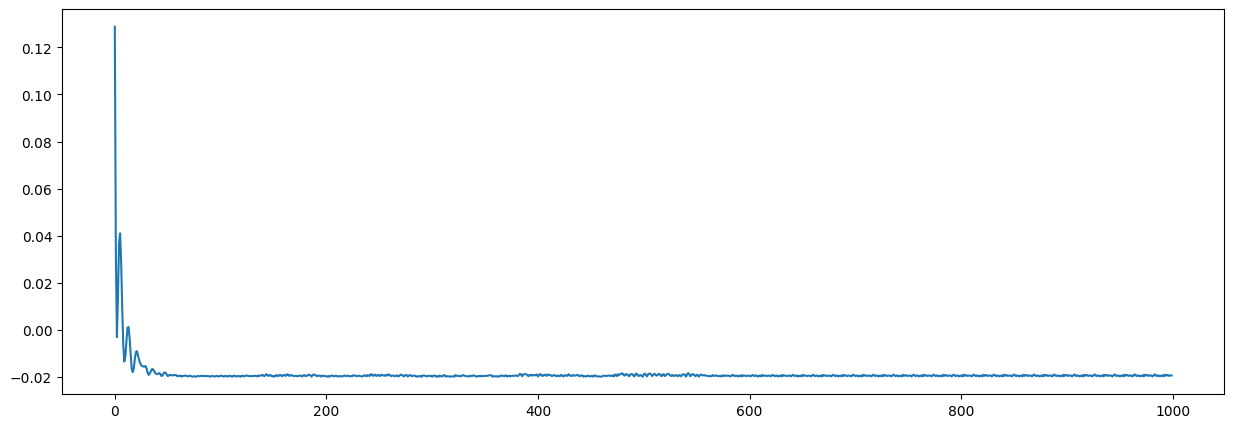

In [139]:
trained_model_state = single_batch_train_model(
    model_state, 
    dataset._data, 
    num_epochs=1000
)

In [15]:
assert False
trained_model_state = train_model(
    model_state, 
    dataloader, 
    num_epochs=1000
)

  0%|          | 0/1000 [00:00<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
from flax.training import checkpoints

In [ ]:
checkpoints.save_checkpoint(
    ckpt_dir='my_checkpoints/',
    target=trained_model_state,
    step=100,
    prefix='my_model',
    overwrite=True,
)

In [ ]:
loaded_model_state = checkpoints.restore_checkpoint(
    ckpt_dir='my_checkpoints/',
    target=model_state,
    prefix='my_model',
)

In [ ]:
trained_model = model.bind(trained_model_state.params)
output = trained_model(dataset._data)
display(output.shape)